In [1]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [2]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews5.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)

# Preprocessing

In [3]:
x = df["text"]
y = df["label"].values

In [4]:
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [5]:
def get_sequence_of_tokens(corpus):
    
    
    total_words = len(tokenizer.word_index) + 1
    
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [6]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.5, random_state=42)

# Setting up LSTM


In [8]:
def build_model():
  opt = Adam(lr=0.001)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(total_words, 128))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.7, recurrent_dropout=0.7, return_sequences=True)))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
  model.add(tf.keras.layers.Dense(6, kernel_regularizer = regularizers.l1_l2(l1=0.01, l2=0.01)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

lstm_model = build_model()

In [9]:
!rm -r /tmp/logs/

In [10]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

Fitting the model takes approximately 5 minutes.

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_lstm = lstm_model.fit(x_train, y_train, epochs = 5, validation_split = 0.1, 
                              callbacks = [tb_callback, checkpoint])

Epoch 1/5
 1/46 [..............................] - ETA: 0s - loss: 1.6643 - accuracy: 0.5625WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
46/46 [==============================] - ETA: 0s - loss: 1.4697 - accuracy: 0.5150
Epoch 00001: val_loss improved from inf to 1.27756, saving model to /tmp/sentiment_analysis.hdf5
46/46 [==============================] - 44s 957ms/step - loss: 1.4697 - accuracy: 0.5150 - val_loss: 1.2776 - val_accuracy: 0.4756
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.9864 - accuracy: 0.7456
Epoch 00002: val_loss improved from 1.27756 to 0.85107, saving model to /tmp/sentiment_analysis.hdf5
46/46 [==============================] - 42s 903ms/step - loss: 0.9864 - accuracy: 0.

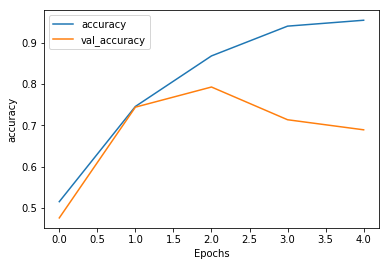

In [12]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()

plot_graphs(history_lstm, 'accuracy')

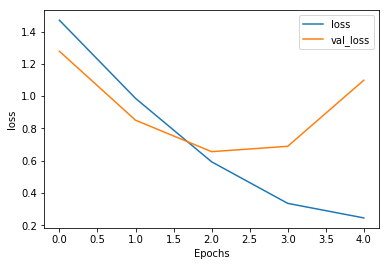

In [13]:
plot_graphs(history_lstm, 'loss')

In [14]:
results = lstm_model.evaluate(x_test, y_test)
print(results)

52/52 [==============================] - 7s 142ms/step - loss: 0.9041 - accuracy: 0.7460
[0.904063880443573, 0.7460220456123352]
